In [4]:
%matplotlib inline
# 便于在jupyter中显示图像，inline表示将图像嵌入到jupyter中
import torch
import random
from d2l import torch as d2l

# 生成数据集，构造一个带有噪声的线性数据集

In [5]:
def synthetic_data(w, b, num_examples):  # @save
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 生成一个服从正态分布(0,1)的数据集
    y = torch.matmul(X, w) + b # 矩阵乘法
    y += torch.normal(0, 0.01, y.shape) # 添加噪声
    return X, y.reshape((-1, 1)) # 返回X和y,y的形状为(num_examples,1)

In [6]:
# 通过函数构造数据集
true_w = torch.tensor([2, -3.4]) #与X相乘的权重
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
# d2l内置了synthetic_data函数，可以直接调用

# 绘制数据集的散点图

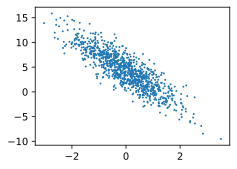

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);
# detach()返回一个新的tensor，从当前计算图中分离下来的，但是仍指向原变量的存放位置

# 读取数据集


In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) # 生成一个从0到num_examples-1的列表
    random.shuffle(indices) # 用于将一个列表中的元素打乱顺序，不会生成新的列表，只是将原列表的次序打乱
    # 随机读取小批量
    for i in range(0, num_examples, batch_size): # 从0到num_examples，每次增加batch_size
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        # 生成一个从i到min(i+batch_size,num_examples)的列表
        yield features[batch_indices], labels[batch_indices]
        # yield关键字用于生成器，返回一个生成器对象

#  模型函数定义

In [9]:
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 定义模型
def linreg(X, w, b):  #@save
    """线性回归模型。"""
    return torch.matmul(X, w) + b

# 定义损失函数
def squared_loss(y_hat, y):  #@save
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 # 返回一个张量，张量的形状与y_hat相同

# 定义优化算法
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降。"""
    with torch.no_grad(): # 禁用梯度计算
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 训练函数

In [10]:
lr=0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(10, features, labels):
        l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失
        l.sum().backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, 10)  # 使用小批量随机梯度下降迭代模型参数

        with torch.no_grad():
            train_l = loss(net(features, w, b), labels)
            print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 15.854240
epoch 1, loss 15.222381
epoch 1, loss 14.300859
epoch 1, loss 13.167009
epoch 1, loss 12.249252
epoch 1, loss 11.666005
epoch 1, loss 11.395910
epoch 1, loss 10.360997
epoch 1, loss 9.522530
epoch 1, loss 8.760991
epoch 1, loss 8.055017
epoch 1, loss 7.496658
epoch 1, loss 6.923446
epoch 1, loss 6.623777
epoch 1, loss 6.064085
epoch 1, loss 5.731276
epoch 1, loss 5.465603
epoch 1, loss 5.301898
epoch 1, loss 4.916120
epoch 1, loss 4.609013
epoch 1, loss 4.312903
epoch 1, loss 4.119526
epoch 1, loss 3.895027
epoch 1, loss 3.689915
epoch 1, loss 3.570911
epoch 1, loss 3.451200
epoch 1, loss 3.231580
epoch 1, loss 3.008100
epoch 1, loss 2.744877
epoch 1, loss 2.566476
epoch 1, loss 2.379251
epoch 1, loss 2.280772
epoch 1, loss 2.202456
epoch 1, loss 2.060442
epoch 1, loss 1.960301
epoch 1, loss 1.882210
epoch 1, loss 1.786742
epoch 1, loss 1.679522
epoch 1, loss 1.583968
epoch 1, loss 1.469630
epoch 1, loss 1.316108
epoch 1, loss 1.246140
epoch 1, loss 1.177080
epo

In [11]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0002, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0002], grad_fn=<RsubBackward1>)
